In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
drive.mount('/content/gdrive')
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Creditcard/creditcard.csv')
card_df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
from sklearn.model_selection import train_test_split

## 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_processed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy


def get_train_test_dataset(df):

  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)

  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]

  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  #stratify = 지정한 data의 비율을 유지. 라벨 셋인 y가 75%의 1과 25%의 0일 경우 데이터 셋도 75%, 25% 유지한 채 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

  # 학습과 테스트 데이터 셋 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


In [88]:
print ('학습 데이터 레이블 값 비율')
print (y_train.value_counts() / y_train.shape[0] * 100)
print ('테스트 데이터 레이블 값 비율')
print (y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print ('오차 행렬')
  print (confusion)

  # ROC-AUC print 추가
  print ('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743


LightGBM을 이용한 모델 생성. 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가할 것이기에 이를 위한 별도의 함수 생성

In [0]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 셋을 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)


본 데이터 셋은 극도로 뷸균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 함

In [13]:
from lightgbm import LGBMClassifier

# n_jobs = -1은 컴퓨터의 모든 코어를 사용 이외에는 개수 지정
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs= -1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831


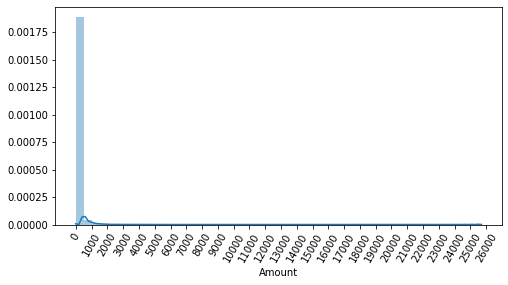

In [90]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

로지스틱 회귀는 선형 모델이며, 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다.

Amount, 즉 카드 사용 금액이 1000불 이하인 데이터가 대부분이며, 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다.

Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정을 진행. 이를 위해 앞에서 만든 get_preprocessed_df()함수를 다음과 같이 사이킷런의 StandardScaler 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경.

In [96]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.

def get_preprocessing_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)

  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy


# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print ('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print ('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946, F1: 0.7097, AUC:0.9609
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC:0.9797


정규 분포 형태로 Amount 피처값을 변환후 테스트 데이터 셋에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지 않음

이번에는 StandardScaler가 아니라 로그 변환을 수행. 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법중에 하나임. 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선함.

In [0]:
def get_processed_df(df=None):
  df_copy = df.copy()

  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

이제 Amount 피처를 로그 변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인

In [93]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print ('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print ('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946, F1: 0.7097, AUC:0.9609
### LightGBM 예측 성능 ###
오차 행렬
[[85261    34]
 [   74    74]]
정확도: 0.9987, 정밀도: 0.6852, 재현율: 0.5000, F1: 0.5781, AUC:0.7531


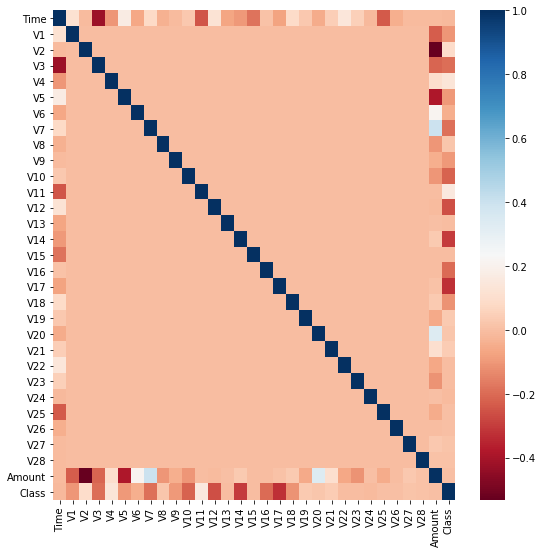

In [3]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [5]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud 에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

outlier_index = get_outlier(card_df, column='V14')
print ('이상치 데이터 인덱스: ', outlier_index)

이상치 데이터 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [14]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)

  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print ('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train = y_train, tgt_test = y_test)
print ('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC:0.9831


위의 경우 이상치 데이터를 제거 후 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었다. 로지스틱 회귀의 경우 재현율이 60%에서 67%로, LightGBM도 76%에서 82%로 증가했음

다음으로는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가한다. 주의점은 SMOTE를 적용할 때는 반드시 학습 데이터 셋만 오버 샘플링 해야 한다. 

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print ('SMOTE를 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print ('SMOTE를 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE를 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE를 적용 후 레이블 값 분포: 
 1    199020
0    199020
dtype: int64


학습 전 데이터 셋은 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398,040건으로 데이터가 증식됐다. 그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020건으로 생성됐다. 이렇게 생성된 학습 데이터 셋을 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능 평가를 진행한다.

In [17]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만 반대로 정밀도가 5.4%로 급격히 저하된다. 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것이다. 분류 결정 임계값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떤 문제가 발생하고 있는지 시각적으로 확인한다.

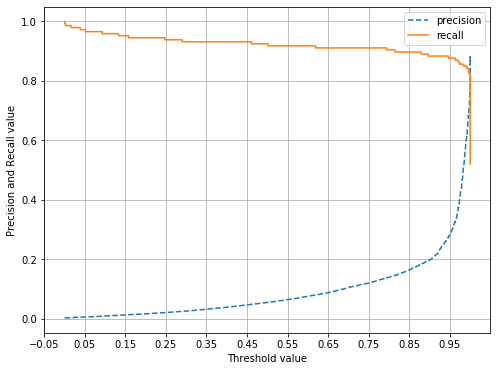

In [23]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값 0.99에서 재현율과 정밀도의 트레이드 오프 관계가 발생한다. 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못함. 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 셋 학습/예측/평가를 수행함

In [24]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9789
